In [ ]:
import tqdm  # TODO: Agregar un poetry o requirements...
import json
import pandas as pd
import requests

SHEET_ID = '1b6h2RApBs2xbN6-eGVvxH68EALKDklvS91fb7d_IVz4'

# ID de cada sheet
# usuarios -> 102021014
# registros -> 2103959160
# usuarios-all -> 1608673456
# registros-all -> 1249987488
SHEET_TAB_ID = '2103959160'
SHEET_URL = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={SHEET_TAB_ID}'

SHEET_URL

'https://docs.google.com/spreadsheets/d/1b6h2RApBs2xbN6-eGVvxH68EALKDklvS91fb7d_IVz4/export?format=csv&gid=2103959160'

In [ ]:
df_registros = pd.read_csv(SHEET_URL)
df_registros.head()

,Timestamp,Padron,Carrera,Mapa
0,9/14/2022 17:09:50,791799,industrial,"{""materias"":[{""id"":""CBC24"",""nota"":7},{""id"":""CB..."
1,9/14/2022 16:02:33,107092,sistemas,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""81.0..."
2,9/14/2022 15:59:55,107037,sistemas,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""81.0..."
3,9/14/2022 15:05:48,103773,industrial,"{""materias"":[{""id"":""CBC24"",""nota"":8},{""id"":""CB..."
4,9/14/2022 12:56:24,999876,informatica,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""62.0..."


In [ ]:
print(f"Remuevo los {df_registros[df_registros['Padron'].isnull()]['Timestamp'].count()} registros invalidos")
df_registros = df_registros[df_registros['Padron'].notnull()]
df_registros.head()

Remuevo los 11 registros invalidos


,Timestamp,Padron,Carrera,Mapa
0,9/14/2022 17:09:50,791799,industrial,"{""materias"":[{""id"":""CBC24"",""nota"":7},{""id"":""CB..."
1,9/14/2022 16:02:33,107092,sistemas,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""81.0..."
2,9/14/2022 15:59:55,107037,sistemas,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""81.0..."
3,9/14/2022 15:05:48,103773,industrial,"{""materias"":[{""id"":""CBC24"",""nota"":8},{""id"":""CB..."
4,9/14/2022 12:56:24,999876,informatica,"{""materias"":[{""id"":""CBC"",""nota"":0},{""id"":""62.0..."


In [ ]:
# TODOs:
# - joinear con "usuarios" para obtener orientacion y tpp/tesis
# - ver si podemos rescatar "checkboxes" del json_mapa
# - ver si podemos migrar el legacy "materia_cuatri" con el nuevo "materia_cuatrimestre"
# - ver por qué hay padrones que no se toman (celda de arriba (teléfono para fede (será tema de formateo de dato numérico en gsheets?)))
dfr = df_registros
df_mapas = None
for idx in tqdm.tqdm(dfr.index):
    json_mapa = json.loads(dfr.loc[idx]['Mapa'])
    df_materias = pd.json_normalize(json_mapa['materias'])
    
    if 'optativas' not in json_mapa:
        df_optativas = pd.DataFrame()
    else:
        df_optativas = pd.json_normalize(json_mapa['optativas'])

    df_materias = df_materias.add_prefix('materia_')
    df_optativas = df_optativas.add_prefix('optativa_')

    df_map = pd.concat([df_materias, df_optativas]).reset_index(drop=True)
    df_map['Padron'] = dfr.loc[idx]['Padron']
    df_map['Carrera'] = dfr.loc[idx]['Carrera']
    df_map['Timestamp'] = dfr.loc[idx]['Timestamp']
    
    if df_mapas is None:
        df_mapas = df_map
    else:
        df_mapas = pd.concat([df_mapas, df_map])

100%|████████████████████████████████████████████████████████████████████████████████████| 4273/4273 [00:37<00:00, 114.75it/s]


In [ ]:
df_mapas.head()

,materia_id,materia_nota,materia_cuatrimestre,Padron,Carrera,Timestamp,optativa_id,optativa_nombre,optativa_creditos,materia_cuatri
0,CBC24,7.0,NaN,791799,industrial,9/14/2022 17:09:50,NaN,NaN,NaN,NaN
1,CBC3,8.0,NaN,791799,industrial,9/14/2022 17:09:50,NaN,NaN,NaN,NaN
2,CBC5,8.0,NaN,791799,industrial,9/14/2022 17:09:50,NaN,NaN,NaN,NaN
3,CBC40,8.0,NaN,791799,industrial,9/14/2022 17:09:50,NaN,NaN,NaN,NaN
4,CBC,0.0,NaN,791799,industrial,9/14/2022 17:09:50,NaN,NaN,NaN,NaN


In [ ]:
df_mapas.shape

(95158, 10)

In [ ]:
# Gente que tiene pensado hacer Simu en el futuro...
df_mapas[df_mapas['materia_id'].isin(['75.26']) & (df_mapas['materia_cuatrimestre'] >= 2023)]['Padron']

33    106295
39    106440
35    104956
48    103775
43    101696
47    105970
33    102889
41    104393
26     97009
42    107378
32     99248
36    105931
40    107964
45    100972
36    102740
39    106004
41    105774
36    104351
31    108645
35      0000
40    109071
34    102342
16    109555
40    103784
42    103785
39    109131
34    104196
36     23456
Name: Padron, dtype: object

In [ ]:
# Vamos a armar un grafazo: nodos -> usuarios. flechas -> cursar misma materia mismo cuatri. peso de flechas -> correlacion entre notas
from itertools import combinations

df_informatica = df_mapas[df_mapas['Carrera'] == 'informatica']

df_informatica = df_informatica[df_informatica['materia_cuatrimestre'].notnull()]
df_informatica = df_informatica[['materia_id', 'materia_nota', 'materia_cuatrimestre', 'Padron']]

d = (df_informatica
     .groupby(['materia_id', 'materia_cuatrimestre'])[['Padron', 'materia_nota']]
     .apply(lambda x : list(combinations(x.values,2)))
     .apply(pd.Series)
     .stack()
     .reset_index(level=0, name='Usuarios')
)

d = d.reset_index()
d[['src', 'dst']] = d['Usuarios'].tolist()
d[['src_padron', 'src_nota']] = d['src'].tolist()
d[['dst_padron', 'dst_nota']] = d['dst'].tolist()

d = d[['src_padron', 'dst_padron', 'materia_cuatrimestre', 'materia_id', 'src_nota', 'dst_nota']]


d = d[((d['src_padron'] == '100029') & (d['dst_padron'] == '101696')) | ((d['src_padron'] == '101696') & (d['dst_padron'] == '100029'))]


/tmp/ipykernel_174474/3844191490.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series)


In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(d, source='src_padron', target='dst_padron', edge_attr=['materia_id','materia_cuatrimestre', 'src_nota', 'dst_nota'], create_using=nx.MultiGraph())

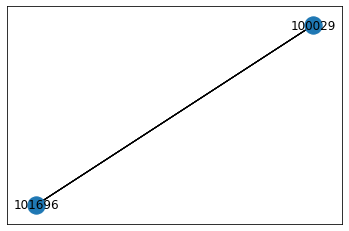

In [ ]:
nx.draw_networkx(G)

In [ ]:
G.edges(data=True)

MultiEdgeDataView([('101696', '100029', {'materia_id': '75.12', 'materia_cuatrimestre': 2019.0, 'src_nota': 9.0, 'dst_nota': 7.0}), ('101696', '100029', {'materia_id': '75.30', 'materia_cuatrimestre': 2022.0, 'src_nota': -1.0, 'dst_nota': -1.0}), ('101696', '100029', {'materia_id': '75.31', 'materia_cuatrimestre': 2020.0, 'src_nota': 10.0, 'dst_nota': 10.0}), ('101696', '100029', {'materia_id': '75.43', 'materia_cuatrimestre': 2021.5, 'src_nota': 7.0, 'dst_nota': 6.0}), ('101696', '100029', {'materia_id': '75.52', 'materia_cuatrimestre': 2021.0, 'src_nota': 10.0, 'dst_nota': 10.0}), ('101696', '100029', {'materia_id': '75.59', 'materia_cuatrimestre': 2021.5, 'src_nota': 7.0, 'dst_nota': 9.0})])